In [3]:
!pip install pyodbc

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import pyodbc

from pandas.plotting import register_matplotlib_converters #Visualization
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from statsmodels.tsa import stattools # statistical tools

# Deep learning libraries

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

#Normalisation library

from sklearn.preprocessing import MinMaxScaler

#metrics libraries

from sklearn.metrics import r2_score

In [25]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '3ac542cf-f945-41bc-bbd6-c9bd687693c0'
resource_group = '200535447-rg'
workspace_name = 'rahulvaghasia'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='micrsoft')
dataset.download(target_path='.', overwrite=False)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/stockpred01/code/Users/200535447/MSFT.csv']

In [27]:
stock = pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/stockpred01/code/Users/200535447/MSFT.csv")

In [28]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,158.779999,160.729996,158.330002,160.619995,155.761795,22622100
1,2020-01-03,158.320007,159.949997,158.059998,158.619995,153.822311,21116200
2,2020-01-06,157.080002,159.100006,156.509995,159.029999,154.219910,20813700
3,2020-01-07,159.320007,159.669998,157.320007,157.580002,152.813766,21634100
4,2020-01-08,158.929993,160.800003,157.949997,160.089996,155.247833,27746500


We are interested in the closing price of a stock on which we want to perform time series analysis.

In [32]:
stock_close = pd.DataFrame(stock['Close'])

It's better to have the DataFrame index in datetime format (pd.datetime) since it makes plotting, and slicing easier

In [33]:
stock_close.index = stock['Date']

In [34]:
stock_close.head()

,Close
Date,
2020-01-02,160.619995
2020-01-03,158.619995
2020-01-06,159.029999
2020-01-07,157.580002
2020-01-08,160.089996


In [35]:
stock_close.describe()

,Close
count,252.000000
mean,192.909484
std,22.966209
min,135.419998
25%,174.297504
50%,201.605003
75%,212.567497
max,231.649994


So, we have data that spans over some 252 days. The maximum MSFT hit during this period was some 231.65 USD, and it also fell in 130 range. 

Let's plot it to get a better look.

## Plotting the Time-series

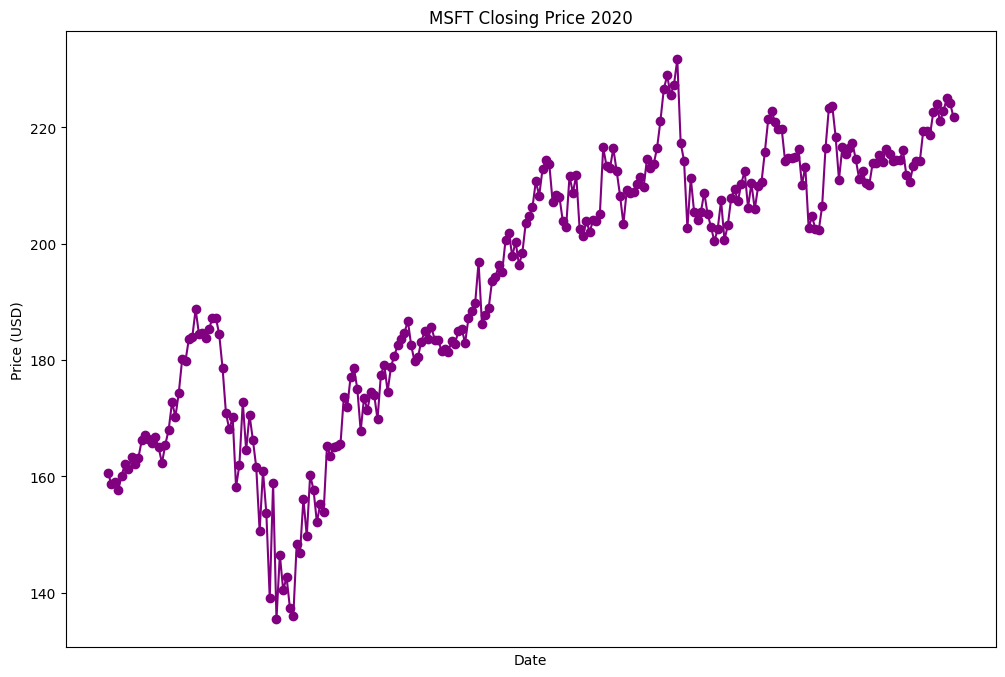

In [55]:
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(stock_close.index.values,
        stock_close['Close'].values,
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="Price (USD)",
       title="MSFT Closing Price 2020")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))

plt.show()

## Autocorrelation plot

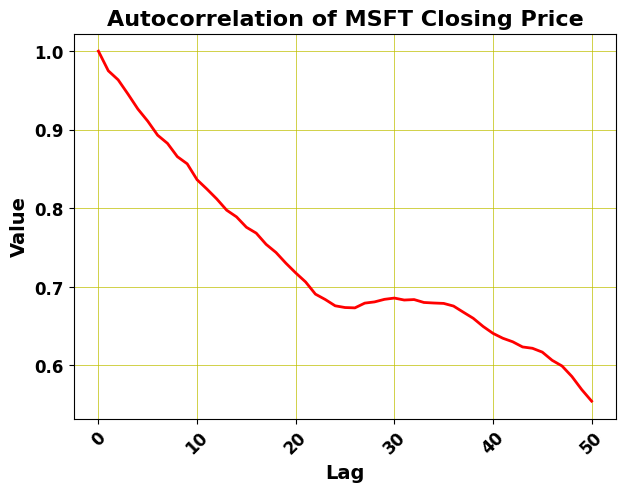

In [56]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(stock_close,
                                                             unbiased=True,
                                                             nlags=50,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation of MSFT Closing Price', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

## Creation of dataset for training

In [57]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [58]:
list_of_attributes = ['Close']

list_of_prev_t_instants = []
for i in range(1,16):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [59]:
df_new = create_regressor_attributes(stock_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5),Close_(t-6),Close_(t-7),Close_(t-8),Close_(t-9),Close_(t-10),Close_(t-11),Close_(t-12),Close_(t-13),Close_(t-14),Close_(t-15)
datetime,,,,,,,,,,,,,,,,
2020-01-24,165.039993,166.720001,165.699997,166.500000,167.100006,166.169998,163.179993,162.130005,163.279999,161.339996,162.089996,160.089996,157.580002,159.029999,158.619995,160.619995
2020-01-27,162.279999,165.039993,166.720001,165.699997,166.500000,167.100006,166.169998,163.179993,162.130005,163.279999,161.339996,162.089996,160.089996,157.580002,159.029999,158.619995
2020-01-28,165.460007,162.279999,165.039993,166.720001,165.699997,166.500000,167.100006,166.169998,163.179993,162.130005,163.279999,161.339996,162.089996,160.089996,157.580002,159.029999
2020-01-29,168.039993,165.460007,162.279999,165.039993,166.720001,165.699997,166.500000,167.100006,166.169998,163.179993,162.130005,163.279999,161.339996,162.089996,160.089996,157.580002
2020-01-30,172.779999,168.039993,165.460007,162.279999,165.039993,166.720001,165.699997,166.500000,167.100006,166.169998,163.179993,162.130005,163.279999,161.339996,162.089996,160.089996


In [60]:
df_new.shape

(237, 16)

## Making the neural Network
I'll be training a straightforward multi-layer perceptron using a 15-node input layer (accounting for each of the 15 past regressor inputs).
There will be two layers that are concealed (yes, two, and that's what makes it "DEEP," nothing more, nothing less). I'll take 60 nodes per into account.
Why 60? After numerous attempts and combinations, I was happy with the outcomes of this one.
Moreover, this exercise will not involve hyperparameter tweaking, which involves changing the model parameters to find the ideal combination.

In [61]:
input_layer = Input(shape=(15), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

2023-03-20 21:11:14.913775: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-20 21:11:15.219955: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-20 21:11:15.220015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stockpred01): /proc/driver/nvidia/version does not exist
2023-03-20 21:11:15.222203: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-20 21:11:15.305670: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2095074999 Hz
2023-03-20 21:11:15.306149: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f297809a0c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023

In [62]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


## Spliting the data

In [65]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (213, 15) (213,)
Shape of validation inputs, validation target: (12, 15) (12,)
Shape of test inputs, test target: (12, 15) (12,)


In [66]:
Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

## Training and Validation

In [67]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/30
43/43 [==============================] - 0s 4ms/step - loss: 0.1082 - val_loss: 0.1016
Epoch 2/30
43/43 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.1129
Epoch 3/30
43/43 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.1154
Epoch 4/30
43/43 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.1211
Epoch 5/30
43/43 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0991
Epoch 6/30
43/43 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0928
Epoch 7/30
43/43 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0954
Epoch 8/30
43/43 [================

## Making predictions on the test set

In [68]:
y_pred = model.predict(X_test_scaled)

In [70]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

## Checking the r2 score

In [71]:
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.6568


## Plotting the predictions

In [72]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Close Price'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Close Price'])

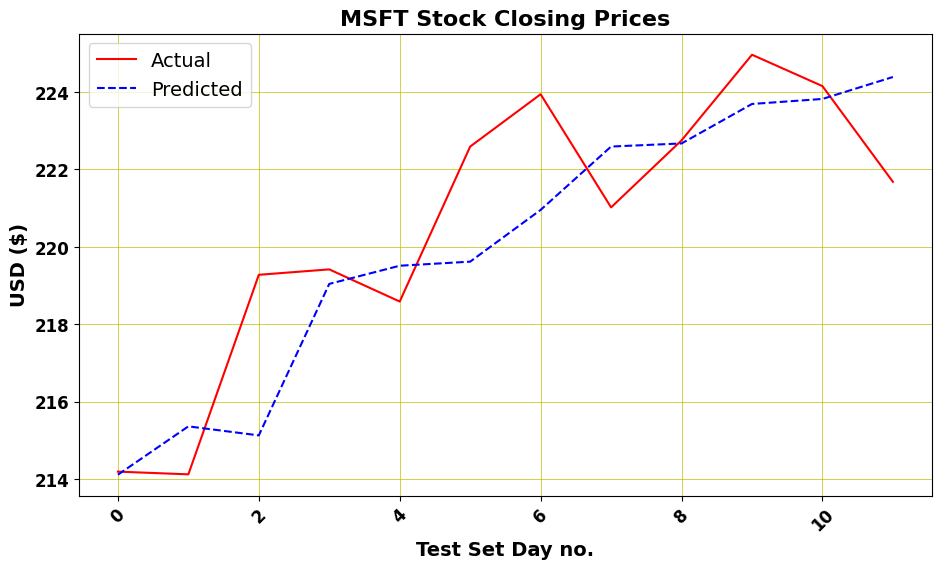

In [74]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('MSFT Stock Closing Prices', weight='bold', fontsize=16)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

I suppose the forecasts are rather accurate, at least for a one-day forecasting period.